# Training Pipeline

Training the best M models

Incluye:

- Tuning de hyperparámetros (con meses históricos)

In [ ]:
!pip install dask[dataframe]

In [ ]:
# Librerias
import os
import pandas as pd
import numpy as np

####################
# funciones y clases
from utils import psi, drift_deflacion

#######
# rutas
# datasets
from config import dataset_file_fe6_6pqt
# optimizacion
from config import db_path
# modelos
from config import modelos_path
# predicciones
from config import pred_path

##########
# pipeline
from processing import ModelPipeline
from sklearn.impute import SimpleImputer


Variables de train y test

In [ ]:
ganancia_acierto = 273000
costo_estimulo = 7000

mes_train_all = [201901, 201902, 201903, 201904, 201905, 201906, 201907, 201908,
                 201909, 201910, 201911, 201912, 202001, 202002, 202003, 202004,
                 202005, 202006, 202007, 202008, 202009, 202010, 202011, 202012,
                 202101, 202102, 202103, 202104, 202105, 202106]

mes_train_ult_3_meses = [202104, 202105, 202106]

mes_train_ult_6_meses = [202101, 202102, 202103, 202104, 202105, 202106]

mes_train_ult_9_meses = [202009, 202010, 202011, 202012, 202101, 202102, 202103, 202104, 202105, 202106]

mes_train_ult_anio = [202006, 202007, 202008, 202009, 202010, 202011, 202012,
                 202101, 202102, 202103, 202104, 202105, 202106]

# mes_train = 202106
mes_test = 202108

semillas = [211777, 174989, 131497, 612223, 234803]

threshold = 0.025

semillas = [437809, 327347, 392879, 455783, 217163]

## Loading data

In [ ]:
data = pd.read_parquet(dataset_file_fe6_6pqt)

## LightGBM 

**Prepro in 6 months and Conceptual FE 6 months**

> comp02_prepro_6.ipynb

> comp02_fe6_6.ipynb

**Usando los últimos 3 meses para optimizar**

### Corriendo pipeline con LightGBM ###
Columns with all NaN values: ['payroll_slope_1_cliente_antiguedad', 'cuenta_corriente_slope_1_cliente_antiguedad', 'visa_consumo_slope_1_cliente_antiguedad', 'comisiones_mantenimiento_slope_1_cliente_antiguedad', 'comisiones_otras_slope_1_cliente_antiguedad', 'payroll_slope_1_foto_mes', 'cuenta_corriente_slope_1_foto_mes', 'visa_consumo_slope_1_foto_mes', 'comisiones_mantenimiento_slope_1_foto_mes', 'comisiones_otras_slope_1_foto_mes']

# Entrenando el modelo base LightGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37519
[LightGBM] [Info] Number of data points in the train set: 164090, number of used features: 318
[LightGBM] [Info] Start training from score -5.118579
[LightGBM] [Info] Start training from score -4.927302
[LightGBM] [Info] Start training from score -0.013319

# Optimizando el modelo


[I 2024-10-09 20:35:10,079] Using an existing study with name 'comp01_v02_pipeline_training_lightgbm_opt_2_fe_agr_3' instead of creating a new one.


Mejores parámetros para lightgbm: {'num_leaves': 35, 'learning_rate': 0.018621897916078312, 'min_data_in_leaf': 72, 'min_gain_to_split': 0.9577598785769601, 'feature_fraction': 0.592949074677414, 'bagging_fraction': 0.8661419525832754, 'bagging_freq': 4, 'max_bin': 147}

# Entrenando el mejor modelo con parámetros optimizados
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] feature_fraction is set=0.592949074677414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.592949074677414
[LightGBM] [Warning] min_gain_to_split is set=0.9577598785769601, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9577598785769601
[LightGBM] [Warning] bagging_fraction is set=0.8661419525832754, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8661419525832754
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagg

c:\Users\santt\.conda\envs\dm_eyf\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


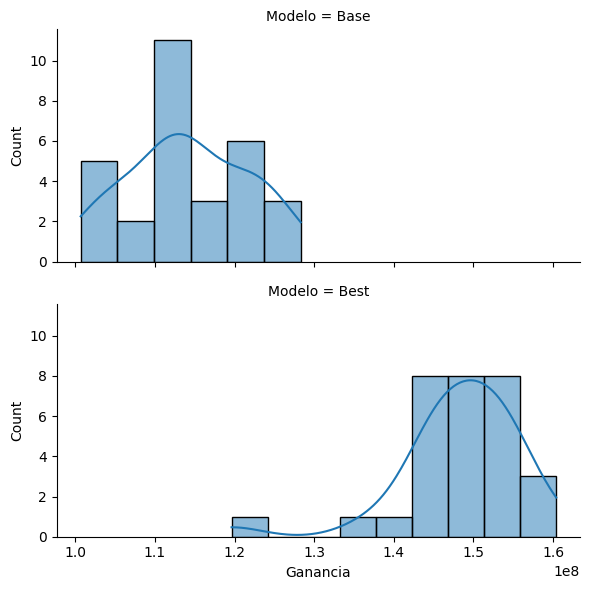

Ganancia media del modelo base: 114161444.44444443
Ganancia media del modelo Best: 148312111.1111111


In [ ]:

# Condiciones de la optimización
s = 1
prepro = 6 # data quality + data drifting
fe = 6 # feature engineering conceptual 6 meses
training = 3 # nueve meses de entrenamiento

print("### Corriendo pipeline con LightGBM ###")
# Inicializar el pipeline con 'lightgbm'
pipeline_lgbm = ModelPipeline(data, semillas, model_type='lightgbm', seed=s, n_jobs=-1)
X_train, y_train = pipeline_lgbm.def_xy(mes_train_ult_3_meses)

# Identify columns with all NaN values
cols_with_all_nan = X_train.columns[X_train.isna().all()]
print("Columns with all NaN values:", cols_with_all_nan.tolist())

# Drop these columns
X_train = X_train.drop(columns=cols_with_all_nan) # extra limpieza

# Imputación de valores faltantes
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
X_train_imp = pd.DataFrame(imp_median.fit_transform(X_train), columns=X_train.columns)

# Opcional: Codificar variables categóricas
# LightGBM puede manejar variables categóricas directamente si se especifican
# Si tus datos tienen variables categóricas, puedes identificarlas y especificarlas en el modelo
categorical_features = [col for col in X_train_imp.columns if X_train_imp[col].dtype == 'object']

# Convertir variables categóricas a 'category' dtype para LightGBM
for col in categorical_features:
    X_train_imp[col] = X_train_imp[col].astype('category')

print("\n# Entrenando el modelo base LightGBM")
pipeline_lgbm.train_base_model(X_train_imp, y_train)

# Definir el almacenamiento para Optuna
storage_name = "sqlite:///" + db_path + "optimization_lgbm.db"
study_name = f"exp_lgbm_pr{prepro}_fe{fe}_tr{training}"

print("\n# Optimizando el modelo")
pipeline_lgbm.optimize_model(
    X_train_imp, y_train,
    storage_name=storage_name,
    study_name=study_name,
    optimize=True,  
    n_trials=150
)

# Entrenar el mejor modelo con parámetros optimizados
print("\n# Entrenando el mejor modelo con parámetros optimizados")
pipeline_lgbm.train_best_model(X_train_imp, y_train)

# Comparar modelos
print("\n# Comparando modelos")
results_base_lgbm_pr6_fe6_tr3, results_best_lgbm_pr6_fe6_tr3 = pipeline_lgbm.compare_models(X_train_imp, y_train)
pipeline_lgbm.plot_comparisons(results_base_lgbm_pr6_fe6_tr3, results_best_lgbm_pr6_fe6_tr3)

Exploring optimization

In [ ]:
###

___